In [7]:
import pandas as pd
import numpy as np
from googletrans import Translator
import string
import time
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
RND_STATE = 515991

%matplotlib inline

## 0. Config

In [2]:
max_string_length = 300

In [3]:
def log_progress(sequence, every=10):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [4]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

## 1. Loading data

### 1.1 Loading and decoding data

In [5]:
data = pd.read_csv('123.csv', sep=',', encoding='utf8')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data_length_start = len(data)
print('Initial length: {0}'.format(data_length_start))
data.describe()

Initial length: 24733


,from,from_id,message,picture,link,name,description,type,created_time,shares,post_id
count,24643,24621,17456,22342,22861,19305,7533,24564,24562,13340,24558
unique,757,744,14711,18236,18901,5899,6114,18,21051,294,21301
top,Russian Tour,_75258759941,Buonanotte!,https://external.xx.fbcdn.net/safe_image.php?d...,http://www.russiantour.com/,Timeline Photos,Russian Gateway Tours,photo,2013-10-09T01:00:00+0000,1,792410744188300_884729708289736
freq,6130,6130,87,217,18,5015,74,16296,14,3119,2


## 2. Preprocessing

### 2.1 Removing nans and unnecessary columns

In [6]:
data = data.drop(['picture', 'link', 'from_id', 'post_id'], axis=1)
data[['shares']] = data[['shares']].fillna(value=0)
data = data.dropna(how='all')
data = data.dropna(subset=['message'])
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))

Removed 7277 elements
New length is 17456


### 2.2 Removing emojis and links

emojis

In [7]:
data['message'] = data['message'].str.replace(u'[^\U00000000-\U0000d7ff\U0000e000-\U0000ffff]', '')

links

In [8]:
data['message'] = data['message'].str.replace(r'^https?:\/\/.*[\r\n]*', '')

### 2.3 Removing advertisements

In [9]:
data = data[~data['from'].str.contains("Visit-Petersburg", na=False)]
print('Removed {0} elements'.format(data_length_start - len(data)))
print('New length is {0}'.format(len(data)))
data.describe()

Removed 8247 elements
New length is 16486


,from,message,name,description,type,created_time,shares
count,16486,16486,13512,4242,16442,16440,16486
unique,599,13310,3853,3436,17,14442,292
top,Russian Tour,,Timeline Photos,Russian Gateway Tours,photo,2013-10-09T01:00:00+0000,0
freq,4480,509,4344,74,10983,14,6912


### 2.4 Stripping texts

In [10]:
data['message'] = data['message'].apply(lambda x: x[:max_string_length].strip())
data['description'] = data['message'].apply(lambda x: x[:max_string_length].strip())

### 2.5 Translating texts into english

In [11]:
def translate_big_text(texts_source, dest = 'en', chunk_size = 800, delay=0):
    translated = []
    chunks_list = list(chunks(texts_source, chunk_size))
    i = 1
    for chunk in log_progress(chunks_list, every=1):
        translated.extend(translate(chunk, delay=delay)) 
        print('Translated chunk #{0} of {1}'.format(i, len(chunks_list)))
        i += 1 
    return translated

In [12]:
def translate(texts_source, dest='en', delay=10):
    translator= Translator()
    translated = []
    err_count = 0
    for text in log_progress(texts_source):
        try:
            translated.append(translator.translate(u''.join(text), dest=dest).text)
        except Exception as e:
            translated.append('')
            err_count += 1
#             print('Error while translating ', text)
#             print(e)
    print('Number of errors: ', err_count)
    print('Waiting {0} sec'.format(delay))
    time.sleep(delay)
    return translated

In [13]:
msg_translations = translate_big_text(data['message'].values)

A Jupyter Widget

A Jupyter Widget

Number of errors:  69
Waiting 0 sec
Translated chunk #1 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #2 of 21


A Jupyter Widget

Number of errors:  32
Waiting 0 sec
Translated chunk #3 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #4 of 21


A Jupyter Widget

Number of errors:  35
Waiting 0 sec
Translated chunk #5 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #6 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #7 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #8 of 21


A Jupyter Widget

Number of errors:  36
Waiting 0 sec
Translated chunk #9 of 21


A Jupyter Widget

Number of errors:  66
Waiting 0 sec
Translated chunk #10 of 21


A Jupyter Widget

Number of errors:  74
Waiting 0 sec
Translated chunk #11 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #12 of 21


A Jupyter Widget

Number of errors:  119
Waiting 0 sec
Translated chunk #13 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #14 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #15 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #16 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #17 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #18 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #19 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #20 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #21 of 21


In [14]:
data['message'] = msg_translations

In [15]:
print('Number of skipped = ', 672)

Number of skipped =  672


In [16]:
descr_translations = translate_big_text(data['description'].values)

A Jupyter Widget

A Jupyter Widget

Number of errors:  4
Waiting 0 sec
Translated chunk #1 of 21


A Jupyter Widget

Number of errors:  25
Waiting 0 sec
Translated chunk #2 of 21


A Jupyter Widget

Number of errors:  19
Waiting 0 sec
Translated chunk #3 of 21


A Jupyter Widget

Number of errors:  18
Waiting 0 sec
Translated chunk #4 of 21


A Jupyter Widget

Number of errors:  88
Waiting 0 sec
Translated chunk #5 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #6 of 21


A Jupyter Widget

Number of errors:  2
Waiting 0 sec
Translated chunk #7 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #8 of 21


A Jupyter Widget

Number of errors:  14
Waiting 0 sec
Translated chunk #9 of 21


A Jupyter Widget

Number of errors:  7
Waiting 0 sec
Translated chunk #10 of 21


A Jupyter Widget

Number of errors:  64
Waiting 0 sec
Translated chunk #11 of 21


A Jupyter Widget

Number of errors:  40
Waiting 0 sec
Translated chunk #12 of 21


A Jupyter Widget

Number of errors:  90
Waiting 0 sec
Translated chunk #13 of 21


A Jupyter Widget

Number of errors:  53
Waiting 0 sec
Translated chunk #14 of 21


A Jupyter Widget

Number of errors:  47
Waiting 0 sec
Translated chunk #15 of 21


A Jupyter Widget

Number of errors:  23
Waiting 0 sec
Translated chunk #16 of 21


A Jupyter Widget

Number of errors:  50
Waiting 0 sec
Translated chunk #17 of 21


A Jupyter Widget

Number of errors:  43
Waiting 0 sec
Translated chunk #18 of 21


A Jupyter Widget

Number of errors:  14
Waiting 0 sec
Translated chunk #19 of 21


A Jupyter Widget

Number of errors:  26
Waiting 0 sec
Translated chunk #20 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #21 of 21


In [17]:
data['description'] = descr_translations

In [18]:
print('Number of skipped = ', 559)

Number of skipped =  559


In [48]:
names_translations = translate_big_text(data['from'].values)

A Jupyter Widget

A Jupyter Widget

Number of errors:  41
Waiting 0 sec
Translated chunk #1 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #2 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #3 of 21


A Jupyter Widget

Number of errors:  29
Waiting 0 sec
Translated chunk #4 of 21


A Jupyter Widget

Number of errors:  23
Waiting 0 sec
Translated chunk #5 of 21


A Jupyter Widget

Number of errors:  17
Waiting 0 sec
Translated chunk #6 of 21


A Jupyter Widget

Number of errors:  40
Waiting 0 sec
Translated chunk #7 of 21


A Jupyter Widget

Number of errors:  13
Waiting 0 sec
Translated chunk #8 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #9 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #10 of 21


A Jupyter Widget

Number of errors:  9
Waiting 0 sec
Translated chunk #11 of 21


A Jupyter Widget

Number of errors:  87
Waiting 0 sec
Translated chunk #12 of 21


A Jupyter Widget

Number of errors:  77
Waiting 0 sec
Translated chunk #13 of 21


A Jupyter Widget

Number of errors:  11
Waiting 0 sec
Translated chunk #14 of 21


A Jupyter Widget

Number of errors:  1
Waiting 0 sec
Translated chunk #15 of 21


A Jupyter Widget

Number of errors:  64
Waiting 0 sec
Translated chunk #16 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #17 of 21


A Jupyter Widget

Number of errors:  40
Waiting 0 sec
Translated chunk #18 of 21


A Jupyter Widget

Number of errors:  83
Waiting 0 sec
Translated chunk #19 of 21


A Jupyter Widget

Number of errors:  10
Waiting 0 sec
Translated chunk #20 of 21


A Jupyter Widget

Number of errors:  0
Waiting 0 sec
Translated chunk #21 of 21


In [49]:
data['from'] = names_translations

In [53]:
print('Number of skipped = ', 545)

Number of skipped =  545


In [80]:
data.to_csv('data_converted.csv', index=False)

In [56]:
data = pd.read_csv('data_converted.csv', sep=',', encoding='utf8')

## 2.7 Moving all words to lower case

In [21]:
data["message"] = data["message"].map(lambda x: x if type(x)!=str else x.lower())
data["description"] = data["description"].map(lambda x: x if type(x)!=str else x.lower())

### 2.8 Tokenizing sentences

In [22]:
data['message'] = data['message'].apply(lambda x: nltk.word_tokenize(str(x)))
data['description'] = data['description'].apply(lambda x: nltk.word_tokenize(str(x)))

### 2.9 Removing stopwords and punctuation

In [23]:
stop_words = stopwords.words('english')
stop_words += (['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '\n', '/n', '-', '#', 'visitpetersburg', 'visitrussia', 'russia', 'the', 'is', 'a'])

In [24]:
data['message'] = data['message'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))
data['description'] = data['description'].apply(lambda x: list(filter(lambda y: y not in stop_words, x)))

# 3. Processing data

## 3.1 Trying to guess gender by name

In [61]:
detector = gender.Detector(case_sensitive=False)

In [70]:
data['from_gender'] = [detector.get_gender((str(name)).split(' ')[0]) for name in data['from'].values]

In [88]:
data['from_gender'].replace([0],['unknown'],inplace=True)

## 3.1 Getting sentiments by Vader algorithm

In [73]:
sid = SentimentIntensityAnalyzer()
message_sent = []
descr_sent = []
data['message'].apply(lambda x: message_sent.append(sid.polarity_scores((" ".join(x)))));
data['description'].apply(lambda x: descr_sent.append(sid.polarity_scores((" ".join(x)))));
data['message_sentiment_vader'] = message_sent
data['description_sentiment_vader'] = descr_sent

## 3.2 Plotting stats 

### 3.2.1 Shares per gender

In [134]:
data.groupby(['from_gender']).sum()

,shares
from_gender,
andy,1
female,2045
male,6333
mostly_female,6908
mostly_male,478
unknown,220974


#### 3.2.1.1 Row data

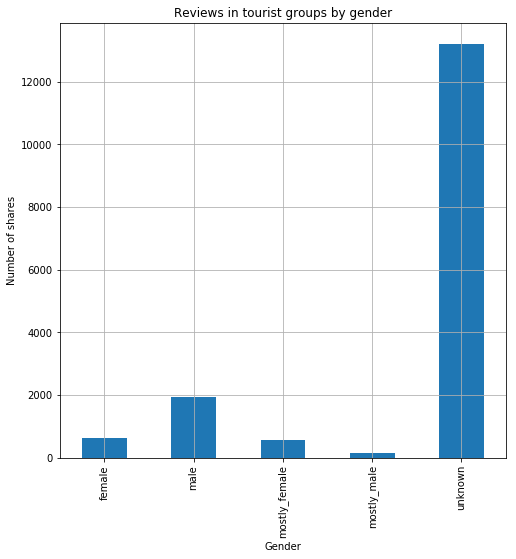

In [132]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy'], axis=0)
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of shares');

#### 3.2.1.2 Only genders

In [147]:
groups = data.groupby(['from_gender']).size()
groups = groups.drop(['andy', 'unknown'], axis=0)
groups['female'] += groups['mostly_female']
groups['male'] += groups['mostly_male']
groups = groups.drop(['mostly_female', 'mostly_male'], axis=0)

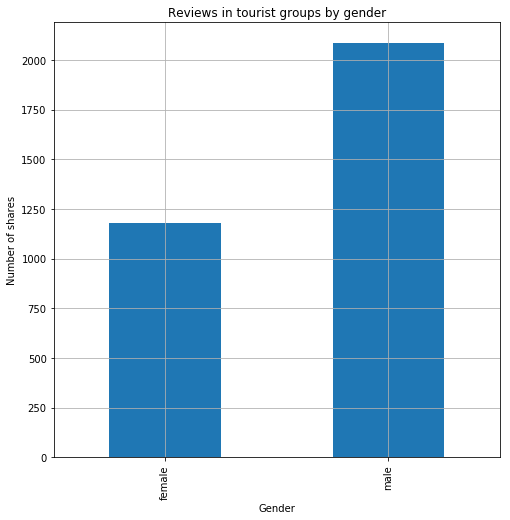

In [148]:
ax = groups.plot(kind = 'bar', grid = True, title = 'Reviews in tourist groups by gender', figsize=(8, 8))
ax.set_xlabel('Gender');
ax.set_ylabel('Number of shares');